## mnist手写数字识别

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# 如果MNIST_data不存在会先下载再读入，pytorch的数据集和这个不一样。
mnist = input_data.read_data_sets('./MNIST_data',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# 28*28*1 灰度图被拉成一行了
mnist.train.images.shape

(55000, 784)

In [4]:
mnist.test.images.shape

(10000, 784)

In [5]:
# 验证集
mnist.validation.images.shape

(5000, 784)

In [6]:
# 循环读，共55000张
train_x,train_y = mnist.train.next_batch(20000)

In [7]:
train_x.shape

(20000, 784)

In [8]:
# 测试集
test_x, test_y = mnist.test.next_batch(5000)

## 图像的可视化

In [9]:
import matplotlib.pyplot as plt

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


<function matplotlib.pyplot.show(*args, **kw)>

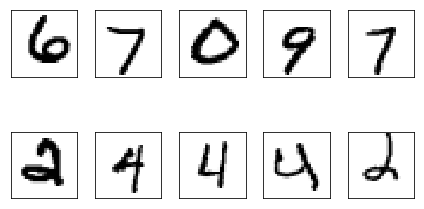

In [10]:
plt.rc('image',cmap='binary')
for i in range(10):#打印10张图
    plt.subplot(2,5,i+1)
    # 打印图用imshow
    plt.imshow(train_x[i].reshape(28,28))
    print(train_y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()
plt.show

## 全连接神经网络

In [11]:
# Sequential 相当于pipeline，会自动执行forward和bp
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [20]:
def model1():
    model=Sequential()
    
    model.add(Dense(100,input_shape=(784,), activation='relu'))
#     model.add(Dense(100,activation='relu'))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy')
    return model

In [21]:
m = model1()

In [22]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = m.fit(train_x,train_y,epochs=10,batch_size=32)

Epoch 1/10
20000/20000 [==============================] - 8s 383us/step - loss: 0.4145
Epoch 2/10
20000/20000 [==============================] - 5s 269us/step - loss: 0.1664
Epoch 3/10
20000/20000 [==============================] - 5s 271us/step - loss: 0.1151
Epoch 4/10
20000/20000 [==============================] - 5s 271us/step - loss: 0.0817
Epoch 5/10
20000/20000 [==============================] - 5s 268us/step - loss: 0.0597
Epoch 6/10
20000/20000 [==============================] - 5s 268us/step - loss: 0.0453
Epoch 7/10
20000/20000 [==============================] - 5s 266us/step - loss: 0.0363
Epoch 8/10
20000/20000 [==============================] - 5s 266us/step - loss: 0.0327
Epoch 9/10
20000/20000 [==============================] - 5s 267us/step - loss: 0.0215
Epoch 10/10
20000/20000 [==============================] - 5s 267us/step - loss: 0.0197


In [24]:
pred = m.predict(test_x)

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
accuracy_score(pred.argmax(1),test_y.argmax(1))

0.97

## 卷积神经网络

In [20]:
import os 
import time
import random
import numpy as np 

In [21]:
model_dir='models'
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

## LeNet

In [22]:
# 不像TensorFlow一样有GPU和CPU版本，安装的时候pytorch会自动识别CPU还是GPU
import torch
# nn就是各种层
import torch.nn as nn
import torch.nn.functional as F
# optim是优化器
import torch.optim as optim
# torchvision有optim的一些东西
import torchvision
# trainsforms相当于pipeline
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [23]:
# # 定一个transforms
# # compose相当于一个pipeline，链式调用
# data_trans = transforms.Compose([
#     transforms.Resize(32),   # resize是防止在多层网络中图像提前变成1*1
#     transforms.ToTensor()
# #    transforms.Normalize(()())?<-参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
# ])

## 图像的Normalize

- 目的：将图片进行归一化的缩放|(x-mean)/std
    - 如果不归一化，可能导致梯度爆炸或者梯度衰减、梯度为零。矩阵是相乘的，网络越深，连乘越多。如果梯度都大于1就会越乘越大，导致梯度爆炸，上溢出；如果梯度小于1，会越来越小，最终导致梯度为0，梯度离散，相当于平滩底部，学不到什么东西。

- 思考：图片归一化后，真的不存在小于0或者大于1的outlier了吗？
    - 不一定，如果数据不均匀，可能导致小于0或者大于1的数据。归一化的公式？

- 思考：归一化哪部分数据？
    - A 训练集 B 评测集 C 训练集+评测集？     A
    - 不可能得到全部数据。

In [24]:
np.mean(mnist.train.images)

0.13070044

In [25]:
np.std(mnist.train.images)

0.30815923

In [26]:
data_trans = transforms.Compose([
    transforms.Resize(32),   # 防止提前出现1*1像素的图像
    transforms.ToTensor(),   # 数据结构转换成torch能接收的
    transforms.Normalize((0.1307,),(0.3081,))  # 参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])

In [27]:
# 会建立一个data目录，train是否是训练集。
train_data = datasets.MNIST('data', train=True, download=True, transform=data_trans)
test_data = datasets.MNIST('data', train=False, download=True, transform=data_trans)

In [28]:
n_train = int(len(train_data)*0.9)
n_validation = len(train_data)-n_train    # 10%做评测集

In [29]:
train_data,valid_data = torch.utils.data.random_split(train_data,[n_train,n_validation])

In [30]:
print(len(train_data),len(valid_data),len(test_data))

54000 6000 10000


In [31]:
batch_size=64

- 目前完成了数据集的制作

In [32]:
# iterator 相当于pytorch里面的一个object，对数据进行切分之后的数据结构。只有训练集有必要shuffle。
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [33]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        #第一层conv1卷积层，in_channel=1,output_channel=6,kernel_size=5*5,input_size=32*32,output_size=28*28
        self.conv1=nn.Conv2d(1,6,5)
        #第二层conv2，output_channel=6 ,kernel 5*5,output_size=10*10,input_size=14*14
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,80)
        self.fc3=nn.Linear(80,10)#不用增加softmax层，在cross_entropy的Loss中自动增加了Softmax
        
    def forward(self,x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(x.shape[0],-1)  #？
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

- 到此神经网络定义完毕

## 载入模型并训练

In [34]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
device

device(type='cuda')

In [33]:
model=LeNet().to(device)

In [34]:
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=10, bias=True)
)

In [17]:
optimizer=optim.Adam(model.parameters())   # 优化器
criterion=nn.CrossEntropyLoss()    # loss

NameError: name 'model' is not defined

In [18]:
criterion=nn.CrossEntropyLoss()    # loss

## 如何评价
- 计算精确度

In [15]:
def accu(fx,y):
    pred=fx.max(1,keepdim=True)[1]
    correct=pred.eq(y.view_as(pred)).sum()#得到该batch的准确度
    acc=correct.float()/pred.shape[0]
    return acc

In [16]:
def train(model,device,iterator,optimizer,criterion):
    epoch_loss=0  #积累变量
    epoch_acc=0   #积累变量
    model.train() #该函数表示PHASE=Train
    
    for (x,y) in iterator:#拿去每一个minibatch
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        fx=model(x)#进行forward
        loss=criterion(fx,y)#计算Loss,train_loss
        type(loss)
        acc=accu(fx,y)#计算精确度，train_accu
        loss.backward()#进行BP
        optimizer.step()#统一更新模型
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
        
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

In [17]:
def evaluate(model,device,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for (x,y) in iterator:
            x=x.to(device)
            y=y.to(device)
            fx=model(x)
            loss=criterion(fx,y)
            acc=accu(fx,y)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
    return epoch_loss/len(iterator),epoch_acc/len(iterator)

## 开始训练

In [21]:
epochs=10
model_path=os.path.join(model_dir,'lenet_mnist.pt')

In [22]:
best_valid_loss=float('inf')

In [23]:
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:#如果是最好的模型就保存到文件夹
        best_valid_loss=valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))

Epoch:1|Train Loss:0.23972646112584672|Train Acc:0.9244729957026893|Val Loss:0.09596572071313858|Val Acc:0.9720744680851063
Epoch:2|Train Loss:0.0694747051506599|Train Acc:0.9781546208530806|Val Loss:0.06675227184561973|Val Acc:0.9782247340425532
Epoch:3|Train Loss:0.05002978890560462|Train Acc:0.98362213669795|Val Loss:0.06574748136831368|Val Acc:0.9805518617021277
Epoch:4|Train Loss:0.03945154916733433|Train Acc:0.9870347057897333|Val Loss:0.06790013114693871|Val Acc:0.981216755319149
Epoch:5|Train Loss:0.03192989953012334|Train Acc:0.9900585011848341|Val Loss:0.06779796327711975|Val Acc:0.9798869680851063
Epoch:6|Train Loss:0.025910181896010704|Train Acc:0.9915395438388626|Val Loss:0.05836796587546098|Val Acc:0.9850398936170213
Epoch:7|Train Loss:0.023935663322940188|Train Acc:0.991928317535545|Val Loss:0.05189152884958411|Val Acc:0.9850398936170213
Epoch:8|Train Loss:0.01990795230009633|Train Acc:0.9935759774881516|Val Loss:0.05808203031978956|Val Acc:0.984375
Epoch:9|Train Loss:0.

In [24]:
model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, device, test_iterator, criterion)

print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.034779636307981365 | Test Acc: 0.9883558917197452 |


## AlexNet

In [49]:
# torch.set_num_threads(100)

In [22]:
data_trans_alexnet = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))#参数mean和std来自于训练集，但是transform本身会在训练和评测的时候都会使用
])
train_data = datasets.MNIST('data',train=True,download=True,transform=data_trans_alexnet)
test_data = datasets.MNIST('data',train=False,download=True,transform=data_trans_alexnet)

In [23]:
n_train=int(len(train_data)*0.9)
n_validation=len(train_data)-n_train

In [24]:
train_data,valid_data=torch.utils.data.random_split(train_data,[n_train,n_validation])

In [25]:
print(len(train_data),len(valid_data),len(test_data))

54000 6000 10000


In [26]:
batch_size = 64

In [27]:
train_iterator=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size)
valid_iterator=torch.utils.data.DataLoader(valid_data,batch_size=batch_size)
test_iterator=torch.utils.data.DataLoader(test_data,batch_size=batch_size)

In [52]:
class AlexNet(nn.Module):
    def __init__(self):#init函数定义的是网络的架构、关键的网络模块、模组
        super(AlexNet,self).__init__()
        self.feature_block=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=11,stride=4,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(64,192,kernel_size=5,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(192,384,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.avgpool=nn.AdaptiveAvgPool2d((6,6))
        self.class_block=nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096,10),
        )
    def forward(self,x):#数据的正向流
        x = self.feature_block(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),256*6*6)
        x = self.class_block(x)
        return x

In [53]:
model = AlexNet()

In [54]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu:0')

In [55]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [56]:
model = model.to(device)

In [57]:
model

DataParallel(
  (module): AlexNet(
    (feature_block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (class_block): Sequential(
      (0): Dropout(p=0.5)
      (1): Linear(in_features=9216, o

In [46]:
optimizer=optim.Adam(model.parameters())

In [47]:
criterion=nn.CrossEntropyLoss()

In [60]:
epochs=10
model_dir='models'
model_path=os.path.join(model_dir,'alexnet_mnist.pt')

In [28]:
best_valid_loss=float('inf')

In [63]:
start = time.time()
for epoch in range(epochs):
    train_loss,train_acc=train(model,device,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,device,valid_iterator,criterion)
    if valid_loss<best_valid_loss:  # 如果是最好的模型就保存到文件夹
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),model_path)
    print('Epoch:{0}|Train Loss:{1}|Train Acc:{2}|Val Loss:{3}|Val Acc:{4}'.format(epoch+1,train_loss,train_acc,valid_loss,valid_acc))
end = time.time()
print("Cost time: {} s.".format(end-start))

Epoch:1|Train Loss:0.32351489656415033|Train Acc:0.8941424763033176|Val Loss:0.07242300928114577|Val Acc:0.979332890282286
Epoch:2|Train Loss:0.09779548081370751|Train Acc:0.972477290726386|Val Loss:0.10621865283935628|Val Acc:0.9686945924099456
Epoch:3|Train Loss:0.08353047891215408|Train Acc:0.9770561809082167|Val Loss:0.05300462175596585|Val Acc:0.984375
Epoch:4|Train Loss:0.07058588084566156|Train Acc:0.9801848835148518|Val Loss:0.04931169888500045|Val Acc:0.9858710106382979
Epoch:5|Train Loss:0.06481341558389402|Train Acc:0.9818572274881516|Val Loss:0.04368885833661052|Val Acc:0.988530585106383
Epoch:6|Train Loss:0.06335728050908074|Train Acc:0.9819683056872038|Val Loss:0.0384771905720551|Val Acc:0.9896387413461157
Epoch:7|Train Loss:0.05232932414060626|Train Acc:0.9853932168246445|Val Loss:0.039285554669480374|Val Acc:0.9905806741815932
Epoch:8|Train Loss:0.0590564951982561|Train Acc:0.9838319510503968|Val Loss:0.035191089238109506|Val Acc:0.9903590425531915
Epoch:9|Train Loss:0.

In [64]:
model.load_state_dict(torch.load(model_path))
test_loss, test_acc = evaluate(model, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.03559933172147365 | Test Acc: 0.9906449044585988 |


## VGG

In [18]:
class VGGBlock(nn.Module):
    def __init__(self,in_channels,out_channels,batch_norm):#在后来改良后的VGG网络增加了BatchNorm
        super(VGGBlock,self).__init__()
        stack=[]
        stack.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        if batch_norm:
            stack.append(nn.BatchNorm2d(out_channels))
        stack.append(nn.ReLU(inplace=True))
        self.model_block=nn.Sequential(*stack)
    def forward(self,x):
        return self.model_block(x)

In [19]:
class VGGNet11(nn.Module):
    def __init__(self,block,pool,batch_norm):#block是一个网络模组抽象，pool也是pooling层的抽象
        super(VGGNet11,self).__init__()
        self.feature_block=nn.Sequential(
            block(1,64,batch_norm), #32*32
            pool(kernel_size=2,stride=2),#16*16
            block(64,128,batch_norm),
            pool(kernel_size=2,stride=2),#8*8
            block(128,256,batch_norm),
            block(256,256,batch_norm),
            pool(kernel_size=2,stride=2),#4*4
            block(256,512,batch_norm),
            block(512,512,batch_norm),
            pool(kernel_size=2,stride=2),#2*2
            block(512,512,batch_norm),
            block(512,512,batch_norm),
            pool(kernel_size=2,stride=2),#1*1
        )
        self.classifier=nn.Linear(512,10)
        
    def forward(self,x):
        x=self.feature_block(x)
        x=x.view(x.shape[0],-1)
        x=self.classifier(x)
        return x

In [20]:
class VGGNet16(nn.Module):
    def __init__(self,block,pool,batch_norm): #block是一个网络模组抽象，pool也是pooling层的抽象
        super(VGGNet16,self).__init__()
        self.feature_block=nn.Sequential(
            block(1,64,batch_norm), #32*32
            block(64,64,batch_norm), #32*32
            pool(kernel_size=2,stride=2),#16*16
            block(64,128,batch_norm),
            block(128,128,batch_norm),
            pool(kernel_size=2,stride=2),#8*8
            block(128,256,batch_norm),
            block(256,256,batch_norm),
            pool(kernel_size=2,stride=2),#4*4
            block(256,512,batch_norm),
            block(512,512,batch_norm),
            block(512,512,batch_norm),
            pool(kernel_size=2,stride=2),#2*2
            block(512,512,batch_norm),
            block(512,512,batch_norm),
            block(512,512,batch_norm),
            pool(kernel_size=2,stride=2),#1*1
        )
        self.classifier=nn.Linear(512,10)
        
    def forward(self,x):
        x=self.feature_block(x)
        x=x.view(x.shape[0],-1)
        x=self.classifier(x)
        return x

In [21]:
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        func(*args,**kwargs)
        end = time.time()
        cost = end - start
        print("Cost time: {} mins.".format(cost/60)) 
    return wrapper

In [33]:
@timer
def train_fit():
    best_valid_loss = float('inf')
    info = 'Epoch:{0} | Train Loss:{1} | Train Acc:{2} | Val Loss:{3} | Val Acc:{4}'
    for epoch in range(epochs):
        train_loss, train_acc = train(model, device, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, device, valid_iterator, criterion)
        if valid_loss < best_valid_loss:  # 如果是最好的模型就保存到文件夹
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_path)
        print(info.format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))


In [34]:
model = VGGNet16(VGGBlock, nn.MaxPool2d, True)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu:0')
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)

In [35]:
model

DataParallel(
  (module): VGGNet16(
    (feature_block): Sequential(
      (0): VGGBlock(
        (model_block): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
      )
      (1): VGGBlock(
        (model_block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
      )
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): VGGBlock(
        (model_block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
        )
      )
      (

In [36]:
optimizer = optim.Adam(model.parameters())   # 优化器
criterion = nn.CrossEntropyLoss()    # loss

In [37]:
epochs = 10
model_path = os.path.join(model_dir,'vggnet16_mnist.pt')

In [38]:
train_fit()

Epoch:1 | Train Loss:0.19393341220535726 | Train Acc:0.9390612658448694 | Val Loss:0.07097932977720778 | Val Acc:0.9781139188624443
Epoch:2 | Train Loss:0.06113600740165084 | Train Acc:0.982912470379147 | Val Loss:0.04401426494834905 | Val Acc:0.988530585106383
Epoch:3 | Train Loss:0.04657110462177068 | Train Acc:0.9873432563661964 | Val Loss:0.040046898965188794 | Val Acc:0.9875886529049975
Epoch:4 | Train Loss:0.03594857168061685 | Train Acc:0.9899967910977902 | Val Loss:0.03436292640547803 | Val Acc:0.9915226063829787
Epoch:5 | Train Loss:0.0333620997722883 | Train Acc:0.9907064573459715 | Val Loss:0.033263351282778575 | Val Acc:0.9906914893617021
Epoch:6 | Train Loss:0.0272576184391587 | Train Acc:0.9925145636096385 | Val Loss:0.04149616933724982 | Val Acc:0.9891954787234043
Epoch:7 | Train Loss:0.024179436739531934 | Train Acc:0.9930576125592417 | Val Loss:0.04127165740554003 | Val Acc:0.9893062945376051
Epoch:8 | Train Loss:0.02496145206384396 | Train Acc:0.9933353080568721 | Val

In [39]:
model.load_state_dict(torch.load(model_path))
test_loss, test_acc = evaluate(model, device, test_iterator, criterion)
print('| Test Loss: {0} | Test Acc: {1} |'.format(test_loss,test_acc))

| Test Loss: 0.029480772674273535 | Test Acc: 0.9918391719745223 |


In [40]:
torch.get_num_threads()

12

In [41]:
torch.cuda.current_device()

0

In [42]:
torch.cuda.device_count()

4